In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import seaborn as sns
from sklearn.model_selection import train_test_split
from datetime import datetime as dt
import warnings
import matplotlib.font_manager as fm
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

plt.rc('font', family='NanumBarunGothic') 

# **1. GS25 판매지수, 4사데이터 시차분석**

In [ ]:
## GS_food
gu = pd.read_excel('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/구_동.xlsx')
gs = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/all_amt.csv',parse_dates=['STD_YMD'])
#gs = gs.drop(['Unnamed: 0'],axis=1)
gs = pd.concat([gs.iloc[:,[0,1]],gs.filter(like='GS')],axis=1)
gs = pd.merge(gs,gu,on='HDONG_NM')
gs['CITY'] = gs['HDONG_GU'].apply(lambda x: x[0:2])
gs_seoul = gs.query('CITY == "서울" & STD_YMD > "2020"')

In [ ]:
gs_food = pd.DataFrame(gs_seoul.groupby(['STD_YMD']).sum().iloc[:,1:4].diff().dropna())
gs_food.columns = ['식사','간식','마실거리']

In [ ]:
## GS ##
gs_sell = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/GS/GS.csv',  encoding='cp949',parse_dates=['OPER_DT'])
for i in range(5,13):
  gs_sell.iloc[:,i] = gs_sell.iloc[:,i].str.replace('%','').astype(float)

dong_list = ['회현동','소공동','광희동','명동','필동','다산동','을지로동','중계1동','상계5동','월계1동','약수동','장충동','상계3.4동','하계1동','동화동']

gs_sell = gs_sell[(gs_sell.OPER_DT >= '2020-02-01') & (gs_sell.PVN == '서울특별시') & (gs_sell.ADMD.isin(dong_list))]
#gs['hpercent'] = gs.LCLS_60_P + gs.LCLS_70_P
gs_sell = gs_sell[['OPER_DT', 'AMT_IND']]
gs_sell = gs_sell.groupby('OPER_DT').sum()
gs_sell = gs_sell.diff().dropna()

## SC ##
scr =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/CARD_SPENDING_RESIDENT.txt', sep='\t',parse_dates = ['STD_DD'])
dong = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/전체동별클러스터링.csv', sep = ',', encoding='UTF-8')
dong_cd = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SC/SC동코드변환.csv', sep = ',',encoding='UTF-8')

def name_a_to_b(data,col,a,b):
  data = data.replace({col:a}, {col:b}, inplace=True)
  return(data)

scr = pd.merge(scr, dong_cd, left_on=['GU_CD', 'DONG_CD'], right_on=['GU_CD', 'HDONG_CD'])
scr = scr.drop(['GU_CD', 'DONG_CD'], axis=1)

# 카테고리 코드 -> 이름
cat_code = [10,20,21,22,30,31,32,33,34,35,40,42,43,44,50,52,60,62,70,71,80,81,92]
cat_name = ['숙박','레저용품','레저업소','문화취미','가구','전기','주방용구',
            '연료판매','광학제품','가전','유통업','의복','직물','신변잡화','서적문구','사무통신',
            '자동차판매','자동차정비','의료기관','보건위생','요식업소','음료식품','수리서비스']
for i in range(len(cat_code)):
  name_a_to_b(scr,'MCT_CAT_CD',cat_code[i],cat_name[i])

scr = scr[(scr.HDONG_NM.isin(dong_list)) & (scr.MCT_CAT_CD == '유통업') & (scr.STD_DD >= '2020-02-01')]
scr = scr.groupby(['STD_DD', 'HDONG_NM']).mean()
scr = scr[['USE_AMT']]

scr = scr.groupby(['STD_DD']).mean()
scr = scr[['USE_AMT']]
sc = scr.diff().dropna()

## SK ##
skt =  pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SK/skt.csv', index_col='Unnamed: 0')
ska = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/SK/ska.csv', index_col='Unnamed: 0')

skt_backup = skt
skt['STD_YMD'] = pd.to_datetime(skt['STD_YMD'].astype(str), format='%Y%m%d') # dtype datetime으로 변경
skt = skt.set_index(['HDONG_NM', 'STD_YMD']) # index로 설정

ska_backup = ska
ska['STD_YMD'] = pd.to_datetime(ska['STD_YMD'].astype(str), format='%Y%m%d') # dtype datetime으로 변경
ska = ska.set_index(['HDONG_NM', 'STD_YMD']) # index로 설정

sk = pd.concat([skt, ska.iloc[:,4:]], axis=1)

skt = skt_backup
skt = skt.set_index('STD_YMD', drop=False)

ska = ska_backup
ska = ska.set_index('STD_YMD', drop=False)

# 구 정보 추가
temp = skt['HDONG_CD'].astype(str).str.slice(start=0, stop=5)
temp = temp.apply(lambda x: '서울 중구' if x == "11140" else x)
temp = temp.apply(lambda x: '서울 노원구' if x == "11350" else x)
temp = temp.apply(lambda x: '대구 중구' if x == "27110" else x)
temp = temp.apply(lambda x: '대구 수성구' if x == "27260" else x)
skt['HGU_NM'] = temp
skt = skt[['STD_YMD', 'STD_YM', 'HGU_NM', 'HDONG_CD', 'HDONG_NM', 'TMST_00', 'TMST_01', 'TMST_02', 'TMST_03', 'TMST_04', 'TMST_05', 'TMST_06', 'TMST_07', 'TMST_08', 'TMST_09', 'TMST_10', 'TMST_11', 'TMST_12', 'TMST_13', 'TMST_14', 'TMST_15', 'TMST_16', 'TMST_17', 'TMST_18', 'TMST_19', 'TMST_20', 'TMST_21', 'TMST_22', 'TMST_23']]

skt = skt[(skt.HDONG_NM.isin(dong_list)) & (skt.STD_YMD >= '2020-02-01') & (skt.STD_YMD <= '2020-05-31')]
skt['people'] = np.sum(skt.iloc[:, 5:30], axis=1)
skt_home = skt[['people']].unstack()
skt_home = skt_home.groupby('STD_YMD').sum()
sk = skt_home.diff().dropna()

## CJ ## 
cj = pd.read_excel('./gdrive/My Drive/빅콘 대상팀/data/CJ/cj.xlsx', error_bad_lines=False, parse_dates=['DL_YMD'])
#cj_home = cj[cj.DL_GD_LCLS_NM.isin(['가구/인테리어', '도서/음반', '디지털/가전'])]
cj = pd.merge(cj, dong_cd, left_on=['HDNG_NM'], right_on=['HDONG_NM'])
cj = cj[(cj.CTPV_NM == '서울특별시') & (cj.HDONG_NM.isin(dong_list)) & (cj.DL_YMD >= '2020-02-01')]
cj_food = cj.groupby(['DL_YMD','DL_GD_LCLS_NM']).sum().query('DL_GD_LCLS_NM=="식품"')
cj_food = cj_food.loc[:,'INVC_CONT']
cj = cj.groupby('DL_YMD').sum()
cj = cj[['INVC_CONT']]
dt_index = pd.date_range(start='20200201', end='20200531')
dt = pd.DataFrame({'date':dt_index})
cj = pd.merge(dt, pd.DataFrame(cj), left_on=['date'], right_on=['DL_YMD'], how='outer').fillna(0)
cj_food = pd.merge(dt, pd.DataFrame(cj_food), left_on=['date'], right_on=['DL_YMD'], how='outer').fillna(0) 
cj = cj.groupby('date').sum()
cj_food = cj.groupby('date').sum()
cj = cj.diff().dropna()
cj_food = cj_food.diff().dropna()

## 코로나 ##
covid = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/covid.csv', sep = ',', parse_dates=['기준일'])
covid = covid[(covid['기준일'] >= '2020-02-01') & (covid['기준일'] <= '2020-05-31')]
covid = covid.set_index('기준일')

covid = pd.DataFrame(covid['일별확진자수'].diff().dropna())

In [ ]:
skt_home = skt[['people']].unstack()
skt_home = skt_home.groupby('STD_YMD').sum()
sk = skt_home.diff().dropna()

Text(0.5, 1.0, 'GS편의점 & 물류 시차')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


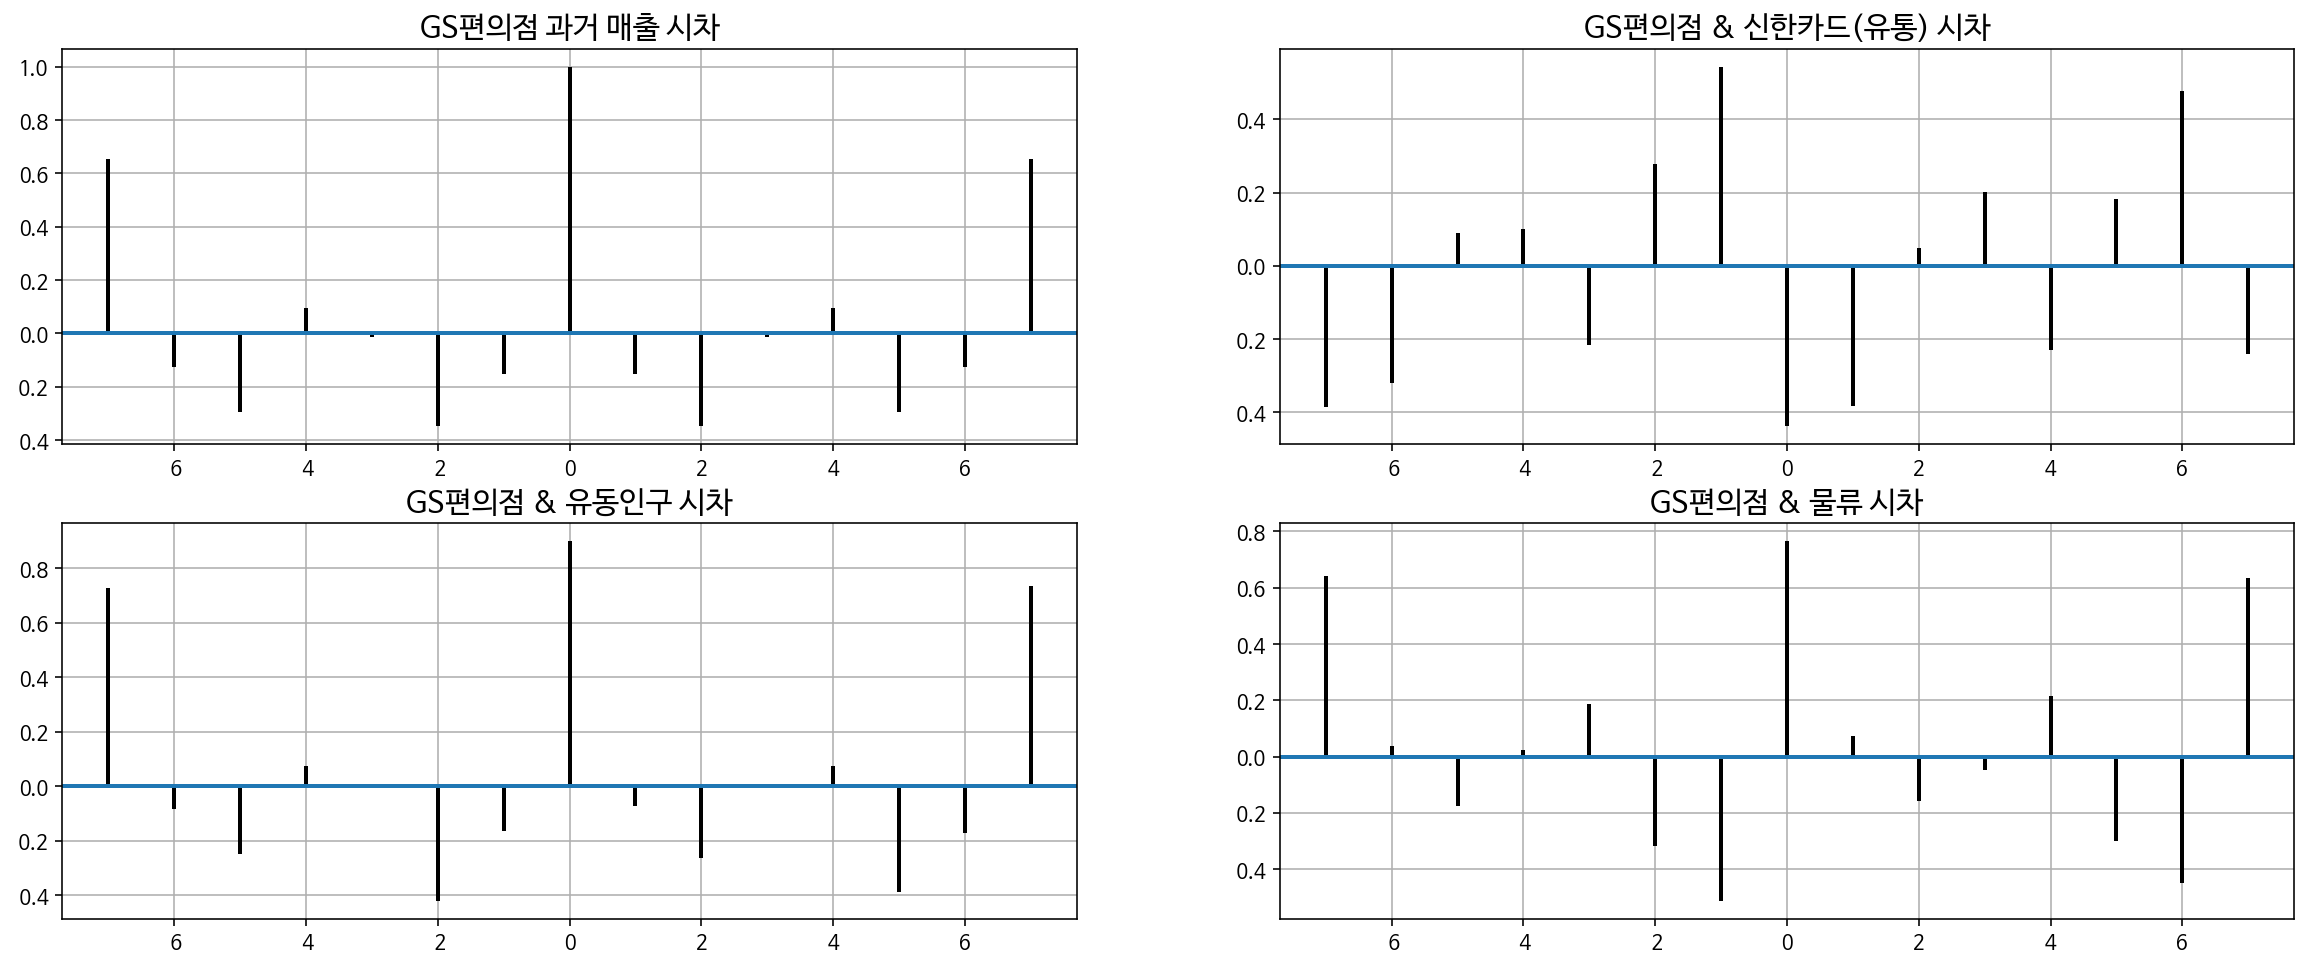

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(221)
plt.acorr(gs_sell['AMT_IND'], usevlines=True, normed=True, maxlags=7, lw=2)
plt.grid(True)
plt.title('GS편의점 과거 매출 시차', fontsize= 15)
#plt.show()

plt.subplot(222)
plt.xcorr(gs_sell['AMT_IND'], sc['USE_AMT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 & 신한카드(유통) 시차', fontsize= 15)
#plt.show()

plt.subplot(223)
plt.xcorr(gs_sell['AMT_IND'], sk, usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 & 유동인구 시차', fontsize= 15)
#plt.show()

plt.subplot(224)
plt.xcorr(gs_sell['AMT_IND'], cj['INVC_CONT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 & 물류 시차', fontsize= 15)
#plt.show()


GS와의 시차(0.4 기준)
- 과거매출 : -7
- 신한카드 : 0,-1
- 유동인구 :0
- 물류 : 0,-1
- 확진자 : 1


# **2. GS25 식사, 4사데이터 시차분석**

Text(0.5, 1.0, 'GS편의점 식사& 물류 시차')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


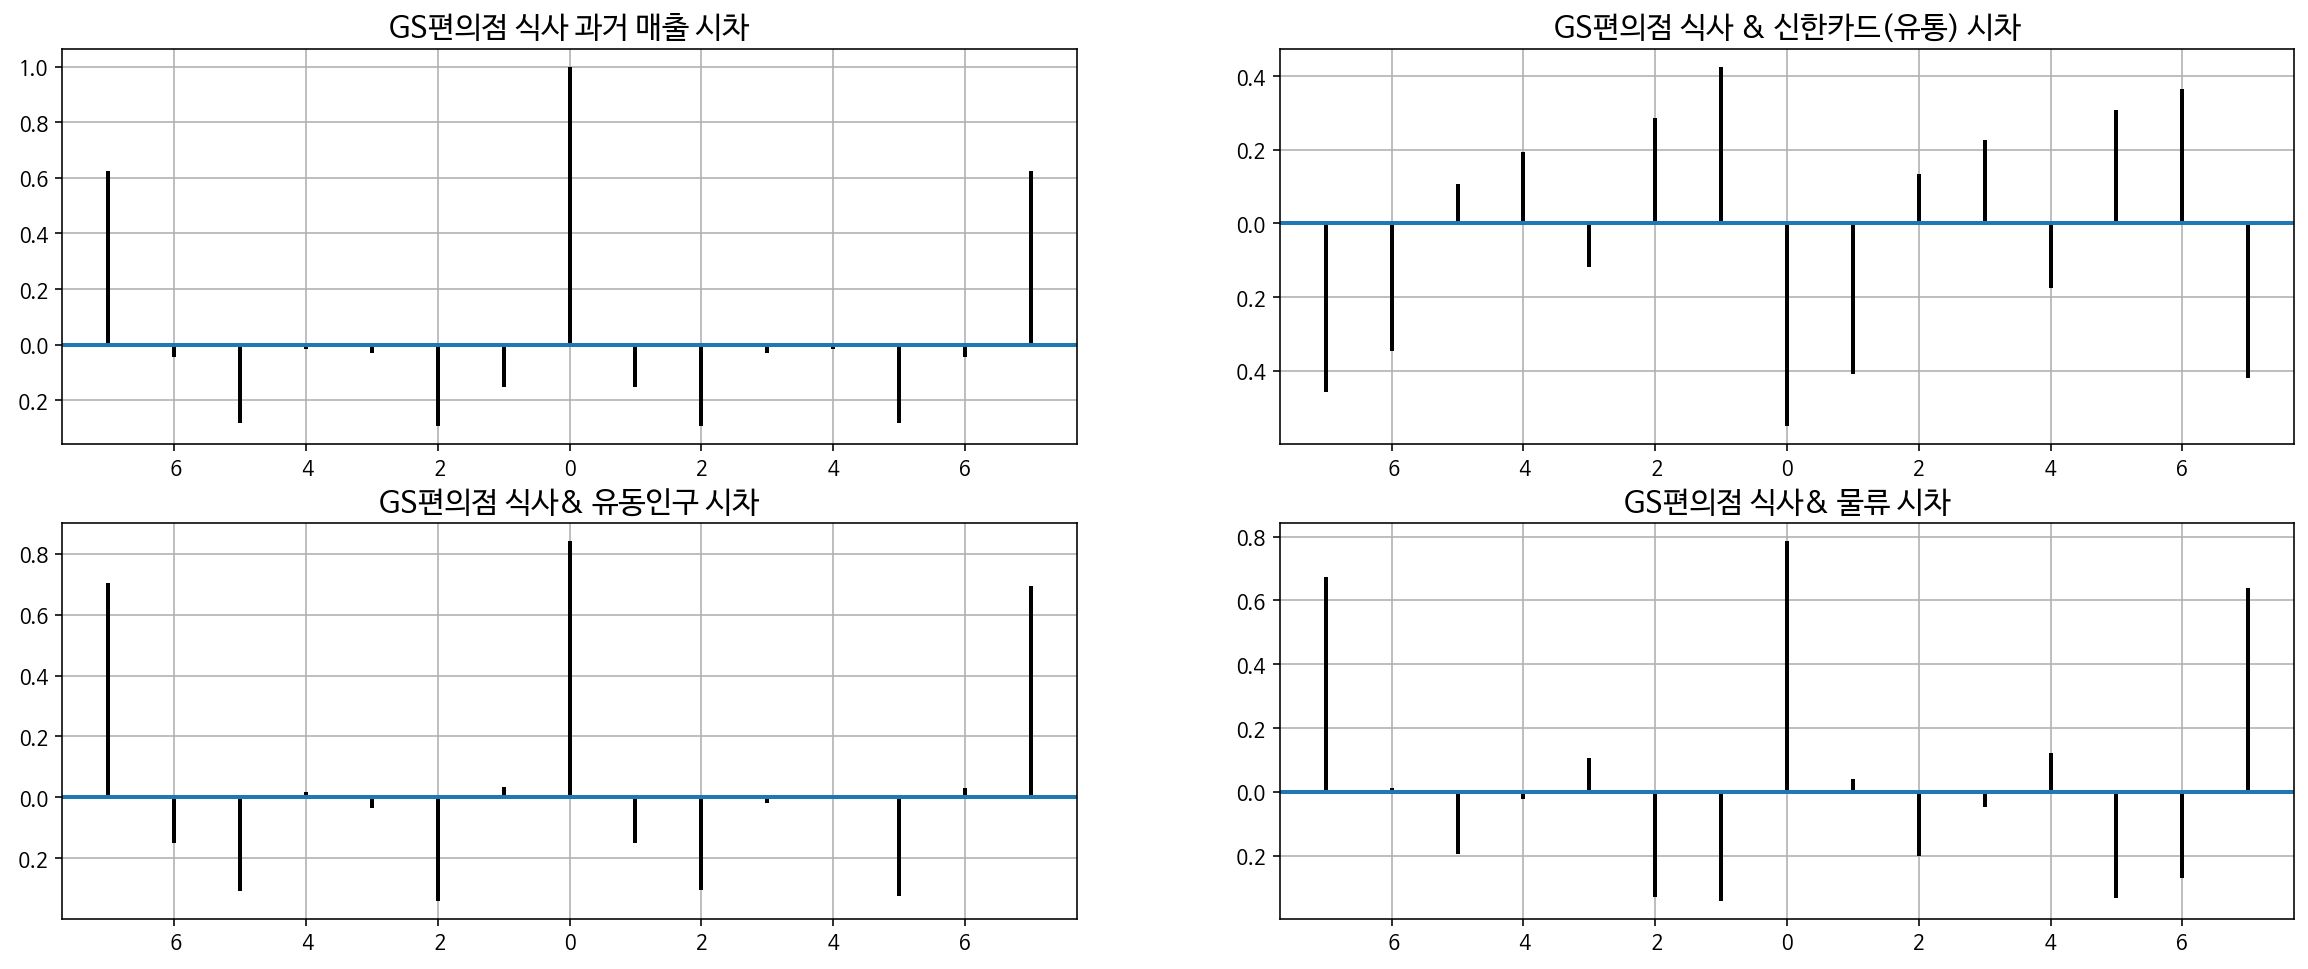

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(221)
plt.acorr(gs_food['식사'], usevlines=True, normed=True, maxlags=7, lw=2)
plt.grid(True)
plt.title('GS편의점 식사 과거 매출 시차', fontsize= 15)
#plt.show()

plt.subplot(222)
plt.xcorr(gs_food['식사'], sc['USE_AMT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 식사 & 신한카드(유통) 시차', fontsize= 15)
#plt.show()

plt.subplot(223)
plt.xcorr(gs_food['식사'], sk, usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 식사& 유동인구 시차', fontsize= 15)
#plt.show()

plt.subplot(224)
plt.xcorr(gs_food['식사'], cj['INVC_CONT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 식사& 물류 시차', fontsize= 15)
#plt.show()


# **3. GS25 간식, 4사데이터 시차분석**

Text(0.5, 1.0, 'GS편의점 간식 & 물류 시차')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


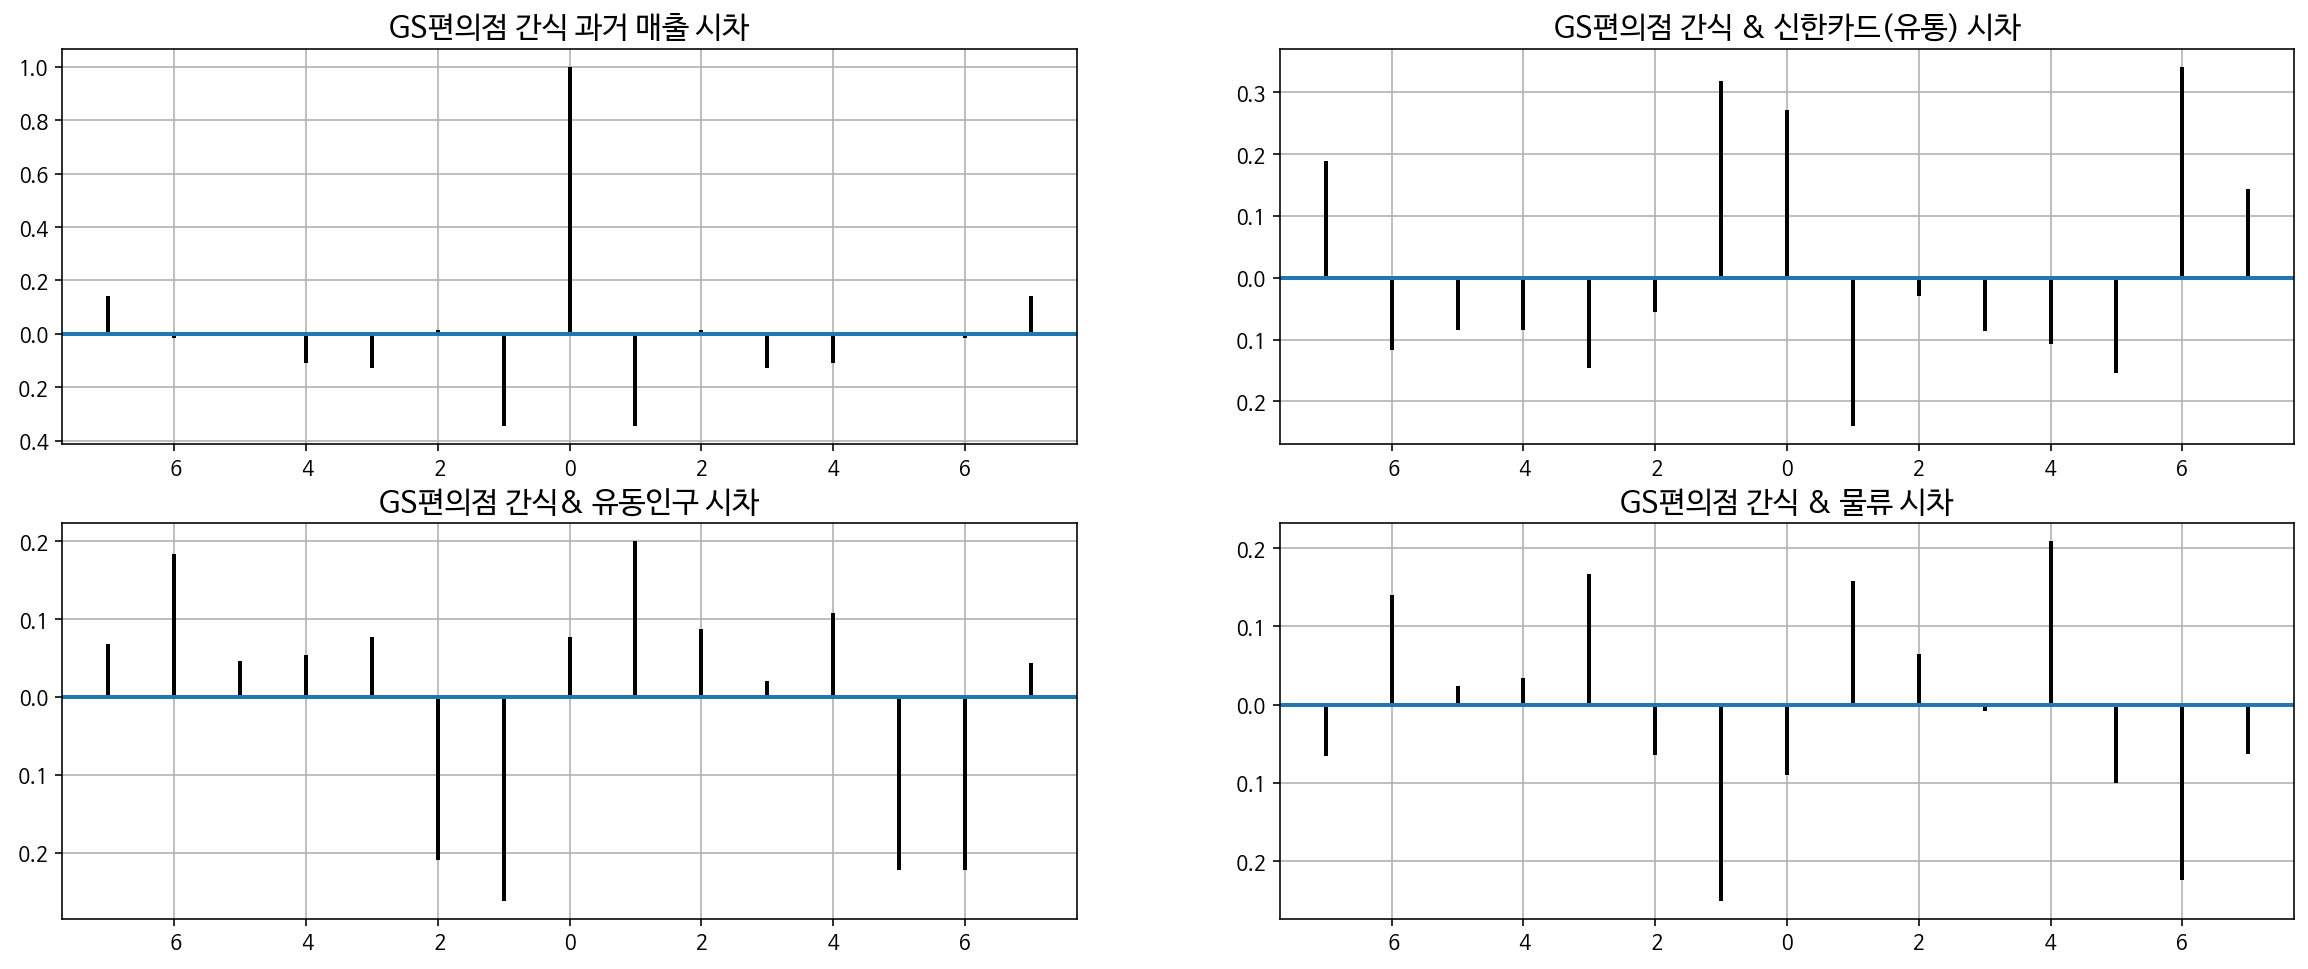

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(221)
plt.acorr(gs_food['간식'], usevlines=True, normed=True, maxlags=7, lw=2)
plt.grid(True)
plt.title('GS편의점 간식 과거 매출 시차', fontsize= 15)
#plt.show()

plt.subplot(222)
plt.xcorr(gs_food['간식'], sc['USE_AMT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 간식 & 신한카드(유통) 시차', fontsize= 15)
#plt.show()

plt.subplot(223)
plt.xcorr(gs_food['간식'], sk, usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 간식& 유동인구 시차', fontsize= 15)
#plt.show()

plt.subplot(224)
plt.xcorr(gs_food['간식'], cj['INVC_CONT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 간식 & 물류 시차', fontsize= 15)
#plt.show()


# **4. GS25 마실거리, 4사데이터 시차분석**

Text(0.5, 1.0, 'GS편의점 마실거리& 물류 시차')

/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.6/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 8722 missing from current font.
  font.set_text(s, 0, flags=flags)


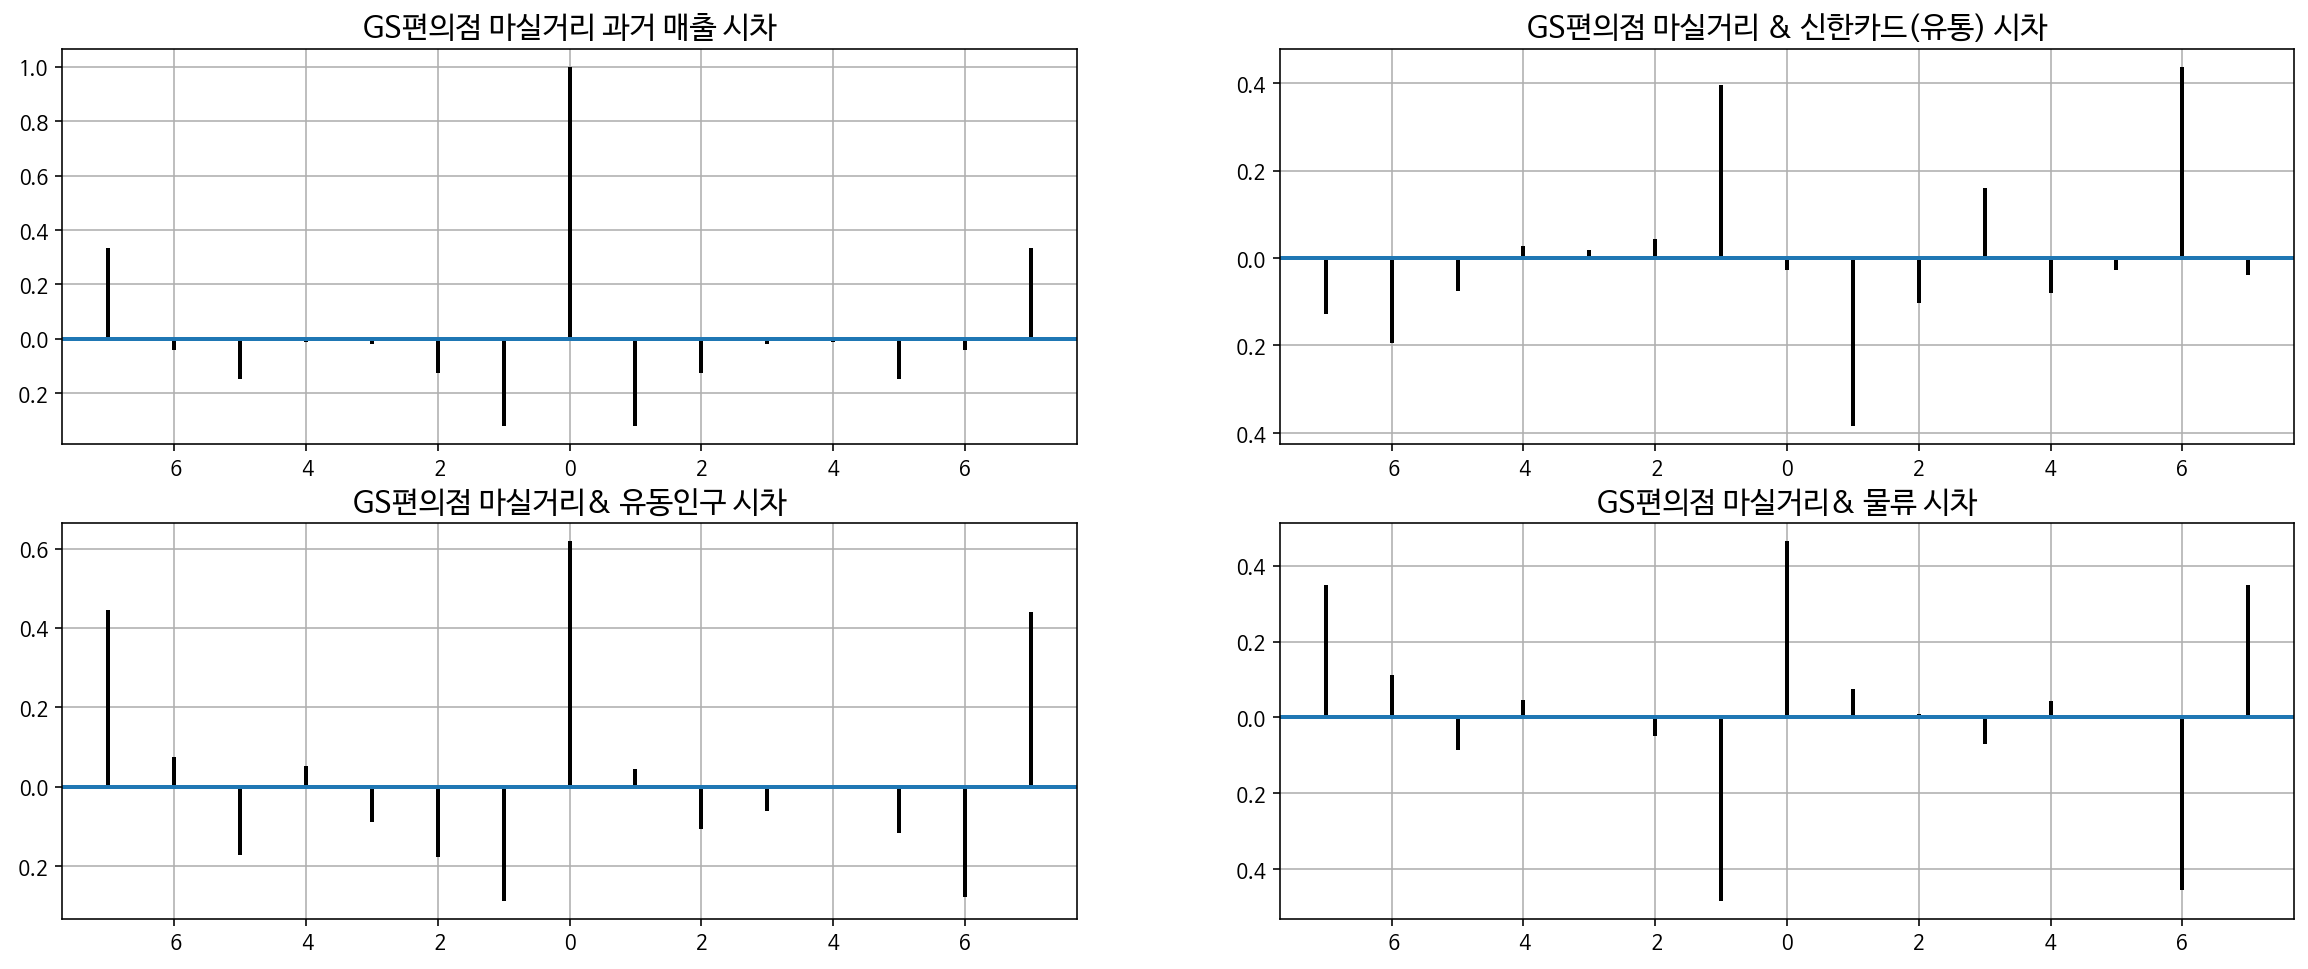

In [ ]:
plt.figure(figsize=(20, 8))
plt.subplot(221)
plt.acorr(gs_food['마실거리'], usevlines=True, normed=True, maxlags=7, lw=2)
plt.grid(True)
plt.title('GS편의점 마실거리 과거 매출 시차', fontsize= 15)
#plt.show()

plt.subplot(222)
plt.xcorr(gs_food['마실거리'], sc['USE_AMT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 마실거리 & 신한카드(유통) 시차', fontsize= 15)
#plt.show()

plt.subplot(223)
plt.xcorr(gs_food['마실거리'], sk, usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 마실거리& 유동인구 시차', fontsize= 15)
#plt.show()

plt.subplot(224)
plt.xcorr(gs_food['마실거리'], cj['INVC_CONT'], usevlines=True, maxlags=7, normed=True, lw=2)
plt.grid(True)
plt.title('GS편의점 마실거리& 물류 시차', fontsize= 15)
#plt.show()

# **5. 모델 final Data Build**

In [ ]:
#Y data
gs_eat = gs_seoul.iloc[:,[0,1,3]].sort_values(['HDONG_NM','STD_YMD'])
gs_snack = gs_seoul.iloc[:,[0,1,4]].sort_values(['HDONG_NM','STD_YMD'])
gs_drink = gs_seoul.iloc[:,[0,1,5]].sort_values(['HDONG_NM','STD_YMD'])

In [ ]:
# x data 준비
gu = pd.read_excel('./gdrive/My Drive/빅콘 대상팀/data/지역데이터/구_동.xlsx')
all = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/all_amt.csv',parse_dates=['STD_YMD'])
#all = all.drop(['Unnamed: 0'],axis=1)
all = pd.merge(all,gu,on='HDONG_NM')
all['CITY'] = all['HDONG_GU'].apply(lambda x: x[0:2])
all = all.query('CITY == "서울" & STD_YMD > "2020"')

In [ ]:
cj = pd.concat([all.iloc[:,[0,1]],all.filter(like='CJ').sum(axis=1)],axis=1)
cj.columns.values[2] = 'cj_0'
sc = pd.concat([all.iloc[:,[0,1]],all.filter(like='AMT_유통업')],axis=1)
sc.columns.values[2] = 'sc_0'
sk = pd.concat([all.iloc[:,[0,1]],all.filter(like='TMST').sum(axis=1)],axis=1)
sk.columns.values[2] = 'sk_0'

In [ ]:
covid = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/covid.csv', sep = ',', parse_dates=['기준일'])
covid = covid[(covid['기준일'] >= '2020-02-01') & (covid['기준일'] <= '2020-05-31')]
covid = covid.set_index('기준일')

covid = pd.DataFrame(covid['일별확진자수']).reset_index()
covid.columns = ['STD_YMD','COVID_CNT']

In [ ]:
seoul_weather = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/일별데이터/WEATHER_SEOUL.csv',parse_dates=['일시'])
seoul_weather = seoul_weather.iloc[:,2:]
seoul_weather.columns =['STD_YMD','기온','최저기온','최고기온','일강수량']
seoul_weather['일교차'] = seoul_weather['최고기온']-seoul_weather['최저기온']
seoul_weather = seoul_weather.interpolate(method='values')  
seoul_weather = seoul_weather[seoul_weather['STD_YMD']>'2020']

In [ ]:
seoul_dust = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/일별데이터/20미세먼지.csv',parse_dates=['date'])
seoul_dust.columns=['STD_YMD','dust']

In [ ]:
seoul_holiday = pd.read_csv('./gdrive/My Drive/빅콘 대상팀/data/일별데이터/20holiday.csv',encoding='cp949',parse_dates=['date'])
seoul_holiday.columns.values[0]='STD_YMD'

In [ ]:
final_data = pd.merge(pd.merge(pd.merge(pd.merge(pd.merge(cj,sc),sk),covid).sort_values(['HDONG_NM','STD_YMD']),seoul_weather,on=['STD_YMD']),seoul_dust,on=['STD_YMD'])

In [ ]:
final_data['sc_m1'] = final_data.groupby(['HDONG_NM'])['sc_0'].shift(1)
final_data['cj_m1'] = final_data.groupby(['HDONG_NM'])['cj_0'].shift(1)
final_data['covid_p1'] = final_data.groupby(['HDONG_NM'])['COVID_CNT'].shift(-1)

In [ ]:
#final_data.to_csv("./gdrive/My Drive/빅콘 대상팀/data/model_data.csv",index=False)

# **[appendix] 시차정보를 사용하지 않는 모델**

In [ ]:
# final data 여러가지 시도
#final_data2 = final_data.drop(['holiday','event'],axis=1) #binary 변수 빼기
#final_data3 = final_data.drop(['holiday','event','COVID_CNT','covid_p1'],axis=1) 
final_data4 = final_data.drop(['COVID_CNT','covid_p1','sc_m1','cj_m1','covid_p1','최저기온','최고기온','일강수량'],axis=1) #최종사용데이터
#lstm_data = final_data.drop(['holiday','event','COVID_CNT','covid_p1','sc_m1','cj_m1'],axis=1)

In [ ]:
def build_data(data,dong,cat):

  X = data.query('HDONG_NM==@dong').reset_index(drop=True)
  
  if cat == "식사":
    eat = gs_eat.query('HDONG_NM==@dong').reset_index(drop=True)
    X['self_m7'] = eat['GS_식사'].shift(7)
    X['y'] = eat['GS_식사']
  elif cat == "간식":
    snack = gs_snack.query('HDONG_NM==@dong').reset_index(drop=True)
    X['self_m7'] = snack['GS_간식'].shift(7)
    X['y'] = snack['GS_간식']
  elif cat == "마실거리":
    drink = gs_drink.query('HDONG_NM==@dong').reset_index(drop=True)
    X['self_m7'] = drink['GS_마실거리'].shift(7)
    X['y'] = drink['GS_마실거리']
  
  X.index = X['STD_YMD']
  del X['STD_YMD'],X['HDONG_NM']

  return X

In [ ]:
def minmax_scalar(X):
  idx = X.index
  col = X.columns

  scalar = MinMaxScaler()
  scaled_X = pd.DataFrame(scalar.fit_transform(X))
  scaled_X.index = idx
  scaled_X.columns = col

  return scaled_X

In [ ]:
import numpy as np
from sklearn.metrics import mean_squared_log_error

def RMSLE_fun(origin,pred):
  rmsle = np.sqrt(mean_squared_log_error(origin+1, pred+1))
  return rmsle

In [ ]:
def train_test_split(n,X,y):
  if isinstance(X, pd.DataFrame):
    total = X.shape[0]
    X_train,X_test = X.iloc[:total-n, :],X.iloc[-n:, :]
    y_train,y_test = y[:total-n],y[-n:]
  else :
    total = X.shape[0]
    X_train,X_test = X[:total-n, :],X[-n:, :]
    y_train,y_test = y[:total-n],y[-n:]
  return X_train,X_test,y_train,y_test

## 1)ARDL

In [ ]:
from sklearn.linear_model import LinearRegression
from statsmodels.api import OLS
from sklearn.preprocessing import MinMaxScaler

In [ ]:
def ARDL(X,dong,cat):
  X=build_data(X,dong,cat)

  #차분
  init = X.loc['2020-05-23','y'].astype('int32')

  X = X.iloc[:,2:].diff(1)
  X = X.dropna()

  y = X['y']
  del X['y']

  #scaling
  scaled_X = minmax_scalar(X)

  #train-test 분리
  X_train,X_test,y_train,y_test = train_test_split(7,scaled_X,y)

  mlr = LinearRegression()
  mlr.fit(X_train, y_train)
  predict = mlr.predict(X_test)
  r2=mlr.score(X_train, y_train)
  #print(OLS(y_train,X_train).fit().summary())

  predict_before_diff = init+predict.cumsum()
  y_test_before_diff = init+y_test.cumsum()

  mse = np.mean((y_test_before_diff-predict_before_diff)**2)
  rmse = np.sqrt(mse)
  rmsle = RMSLE_fun(y_test_before_diff, predict_before_diff)
  
  #print(mse)
  #plt.plot(y)
  #plt.plot(X.index[n:], predict, color='red')
  #plt.xticks(rotation=45)
  #plt.legend(labels=['y', 'Predicted'], bbox_to_anchor=(1.04,1))
  #plt.title('ARDL Model', fontsize=20)
  #print('MSE = {}'.format(mse))
  #return predict_before_diff,y_test_before_diff
  return mse,rmse, rmsle

In [ ]:
warnings.filterwarnings("ignore")

dong = list(gu.query('HDONG_GU =="서울 노원구"').HDONG_NM.unique())+list(gu.query('HDONG_GU =="서울 중구"').HDONG_NM.unique())
cat = ['식사','간식','마실거리']

RMSLE_ARDL=[]
MSE_ARDL=[]
RMSE_ARDL=[]
for j,c in enumerate(cat):
  for i,d in enumerate(dong):
    if d =="상계8동":
      continue
    #print('=============================result of {}============================'.format(d))
    mse,rmse,rmsle=ARDL(final_data4,d,c)
    MSE_ARDL.append(mse)
    RMSE_ARDL.append(rmse)
    RMSLE_ARDL.append(rmsle)
    

In [ ]:
#dong.remove('상계8동')
n=len(dong)
result_ardl = pd.DataFrame({'dong':dong,
                       'rmsle_eat':RMSLE_ARDL[:n],'rmsle_snack':RMSLE_ARDL[n:len(RMSLE_ARDL)-n],'rmsle_drink':RMSLE_ARDL[len(RMSLE_ARDL)-n:],
                       'mse_eat':MSE_ARDL[:n],'mse_snack':MSE_ARDL[n:len(MSE_ARDL)-n],'mse_drink':MSE_ARDL[len(MSE_ARDL)-n:],
                       'rmse_eat':RMSE_ARDL[:n],'rmse_snack':RMSE_ARDL[n:len(RMSE_ARDL)-n],'rmse_drink':RMSE_ARDL[len(RMSE_ARDL)-n:]}).reset_index(drop=True)
result_ardl

,dong,rmsle_eat,rmsle_snack,rmsle_drink,mse_eat,mse_snack,mse_drink,rmse_eat,rmse_snack,rmse_drink
0,월계1동,0.079639,0.139648,0.055330,5.137732,5.539976,5.653296,2.266657,2.353715,2.377666
1,월계2동,0.103827,0.267225,0.099164,9.812036,27.643534,15.666365,3.132417,5.257712,3.958076
2,월계3동,0.059708,0.181435,0.059403,3.119114,26.719530,10.775178,1.766101,5.169094,3.282557
3,공릉2동,0.069805,0.142597,0.061087,3.678851,8.691458,7.182837,1.918033,2.948128,2.680082
4,하계1동,0.102395,0.087581,0.133298,10.247880,7.289083,62.133447,3.201231,2.699830,7.882477
5,하계2동,0.084382,0.130103,0.096002,20.159655,54.219104,46.455568,4.489950,7.363362,6.815832
6,중계본동,0.101682,0.147243,0.081892,15.722681,26.014658,23.915947,3.965184,5.100457,4.890393
7,중계1동,0.109772,0.205490,0.154430,12.640549,29.914700,71.664913,3.555355,5.469433,8.465513
8,중계4동,0.135118,0.110807,0.226111,32.377296,9.685557,160.452589,5.690105,3.112163,12.666988
9,상계1동,0.072491,0.076756,0.103455,3.989191,3.619479,27.083935,1.997296,1.902493,5.204223


In [ ]:
print("ARDL모델의 동별 RMSLE의 평균은 식사:{} 간식:{} 마실거리:{}".format(np.mean(result_ardl.rmsle_eat),np.mean(result_ardl.rmsle_snack),np.mean(result_ardl.rmsle_drink)))
print("ARDL모델의 동별 RMSLE의 총계는 식사:{} 간식:{} 마실거리:{}".format(np.sum(result_ardl.rmsle_eat),np.sum(result_ardl.rmsle_snack),np.sum(result_ardl.rmsle_drink)))

print("ARDL모델의 동별 MSE의 평균은 식사:{} 간식:{} 마실거리:{}".format(np.mean(result_ardl.mse_eat),np.mean(result_ardl.mse_snack),np.mean(result_ardl.mse_drink)))
print("ARDL모델의 동별 MSE의 총계는 식사:{} 간식:{} 마실거리:{}".format(np.sum(result_ardl.mse_eat),np.sum(result_ardl.mse_snack),np.sum(result_ardl.mse_drink)))

ARDL모델의 동별 RMSLE의 평균은 식사:0.11310987390875296 간식:0.1419603400814931 마실거리:0.10860925520230373
ARDL모델의 동별 RMSLE의 총계는 식사:3.7326258389888483 간식:4.684691222689271 마실거리:3.5841054216760235
ARDL모델의 동별 MSE의 평균은 식사:20.202338480010958 간식:18.542528365653755 마실거리:42.73156405995093
ARDL모델의 동별 MSE의 총계는 식사:666.6771698403617 간식:611.9034360665739 마실거리:1410.1416139783807


## 2) XGBoost

In [ ]:
from xgboost import plot_importance, XGBRegressor
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold

In [ ]:
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data, 
                       model, param_grid, cv=5, scoring_fit='neg_mean_squared_error',
                       do_probabilities = False):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=1, 
        scoring=scoring_fit,
        verbose=0
    )
    fitted_model = gs.fit(X_train_data, y_train_data)
    
    if do_probabilities:
      pred = fitted_model.predict_proba(X_test_data)
    else:
      pred = fitted_model.predict(X_test_data)
    
    return fitted_model, pred

In [ ]:
def XGBOOST(X,dong,cat):
  X=build_data(X,dong,cat)

  y = X['y']
  del X['y']

  scaled_X = minmax_scalar(X)
  X_train,X_test,y_train,y_test = train_test_split(7,scaled_X,y)
  xgb = XGBRegressor(objective ='reg:squarederror',seed=0)
  #print(xgb)
  '''
  param_grid = {
      'n_estimators': [100,300,500],
      'eta' : [0.1,0.3],
      'max_depth': [3,5,7,9],
  }
  model, predict = algorithm_pipeline(X_train, X_test, y_train, y_test, xgb, 
                                 param_grid, cv=5)
  '''
  #plot_importance(model, height=0.9)
  xgb.fit(X_train,y_train,eval_set=[(X_test,y_test)],verbose=0)
  predict = xgb.predict(X_test)

  mse = np.mean((y_test-predict)**2)
  rmsle = RMSLE_fun(np.array(y_test),np.array(predict))
  #r2= r2_score(np.array(y_test),np.array(predict))

  return mse,rmsle

In [ ]:
warnings.filterwarnings("ignore")

dong = list(gu.query('HDONG_GU =="서울 노원구"').HDONG_NM.unique())+list(gu.query('HDONG_GU =="서울 중구"').HDONG_NM.unique())
cat = ['식사','간식','마실거리']

RMSLE_XGBOOST=[]
MSE_XGBOOST=[]
for j,c in enumerate(cat):
  for i,d in enumerate(dong):
    if d =="상계8동":
      continue
    #print('=============================result of {}============================'.format(d))
    mse,rmsle=XGBOOST(final_data4,d,c)
    RMSLE_XGBOOST.append(rmsle)
    MSE_XGBOOST.append(mse)

In [ ]:
dong.remove('상계8동')
n=len(dong)
result_xgboost = pd.DataFrame({'dong':dong,
                       'rmsle_eat':RMSLE_XGBOOST[:n],
                       'rmsle_snack':RMSLE_XGBOOST[n:len(RMSLE_XGBOOST)-n],
                       'rmsle_drink':RMSLE_XGBOOST[len(RMSLE_XGBOOST)-n:],
                       'mse_eat':MSE_XGBOOST[:n],
                       'mse_snack':MSE_XGBOOST[n:len(MSE_XGBOOST)-n],
                       'mse_drink':MSE_XGBOOST[len(MSE_XGBOOST)-n:],
                       'rmse_eat':RMSE_ARDL[:n],
                       'rmse_snack':RMSE_ARDL[n:len(RMSE_ARDL)-n],
                       'rmse_drink':RMSE_ARDL[len(RMSE_ARDL)-n:]}).reset_index(drop=True)
result_xgboost

,dong,rmsle_eat,rmsle_snack,rmsle_drink,mse_eat,mse_snack,mse_drink,rmse_eat,rmse_snack,rmse_drink
0,월계1동,0.071206,0.054878,0.076844,4.754965,1.016144,7.571310,2.266657,2.353715,2.377666
1,월계2동,0.075597,0.097734,0.136169,7.060874,4.854114,28.206982,3.132417,5.257712,3.958076
2,월계3동,0.113038,0.067599,0.087430,11.117859,2.977321,19.481231,1.766101,5.169094,3.282557
3,공릉2동,0.083556,0.057639,0.096679,6.143077,1.612820,12.433268,1.918033,2.948128,2.680082
4,하계1동,0.097556,0.085196,0.156163,9.453148,5.682678,62.177967,3.201231,2.699830,7.882477
5,하계2동,0.113752,0.071054,0.114243,33.200198,11.324728,39.180565,4.489950,7.363362,6.815832
6,중계본동,0.097264,0.090510,0.126905,16.283159,10.399603,42.554179,3.965184,5.100457,4.890393
7,중계1동,0.130690,0.081441,0.150871,18.549631,4.749118,46.887779,3.555355,5.469433,8.465513
8,중계4동,0.080445,0.117846,0.176345,8.301635,8.178757,64.026710,5.690105,3.112163,12.666988
9,상계1동,0.075050,0.071833,0.105689,3.662212,2.661270,17.665980,1.997296,1.902493,5.204223


In [ ]:
print("GBM모델의 동별 RMSLE의 평균은 식사:{} 간식:{} 마실거리:{}".format(np.mean(result_xgboost.rmsle_eat),np.mean(result_xgboost.rmsle_snack),np.mean(result_xgboost.rmsle_drink)))
print("GBM모델의 동별 RMSLE의 총계는 식사:{} 간식:{} 마실거리:{}".format(np.sum(result_xgboost.rmsle_eat),np.sum(result_xgboost.rmsle_snack),np.sum(result_xgboost.rmsle_drink)))

print("GBM모델의 동별 MSE의 평균은 식사:{} 간식:{} 마실거리:{}".format(np.mean(result_xgboost.mse_eat),np.mean(result_xgboost.mse_snack),np.mean(result_xgboost.mse_drink)))
print("GBM모델의 동별 MSE의 총계는 식사:{} 간식:{} 마실거리:{}".format(np.sum(result_xgboost.mse_eat),np.sum(result_xgboost.mse_snack),np.sum(result_xgboost.mse_drink)))



GBM모델의 동별 RMSLE의 평균은 식사:0.09632611767725562 간식:0.0999928442823621 마실거리:0.1101613883467116
GBM모델의 동별 RMSLE의 총계는 식사:3.178761883349435 간식:3.29976386131795 마실거리:3.635325815441482
GBM모델의 동별 MSE의 평균은 식사:12.325337595310936 간식:10.539952368716026 마실거리:27.09689927564678
GBM모델의 동별 MSE의 총계는 식사:406.73614064526083 간식:347.81842816762884 마실거리:894.1976760963436
